In [4]:
import musdb
import librosa
import librosa.display
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.losses import binary_crossentropy
from IPython.display import Audio, display
from tqdm import tqdm
import mir_eval


from data_repr_classes import *
from unet_model import u_net

<h2 style="text-decoration:underline">Preprocessing:</h2>

In [9]:
# Data preparation, snippets or full dataset.

mus = musdb.DB(download=True) # snippets

#mus = musdb.DB(root="/Users/lukasfrosslund/Downloads/musdb18") # full dataset

In [10]:
data = Dataset_repr(mus[0:10], test_size=0.2, val_size=0.1, augment=[True, 'basic', 2], freq_repr='stft', cut_off=0)
training_slices_X, training_slices_Y = data.train_slices_mixture, data.train_slices_vocal
validation_slices_X, validation_slices_Y = data.val_slices_mixture, data.val_slices_vocal
test_slices_X, test_slices_Y = data.test_slices_mixture, data.test_slices_vocal

Augmentation: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
Slicing frames: 21it [00:00, 52.81it/s]
Slicing frames: 1it [00:00, 48.09it/s]
Slicing frames: 2it [00:00, 49.12it/s]


<h2 style="text-decoration: underline">Visualizations:</h2>

In [11]:
training_slices_X = training_slices_X[:, :-1, :, :]
training_slices_Y = training_slices_Y[:, :-1, :, :]
validation_slices_X = validation_slices_X[:, :-1, :, :]
validation_slices_Y = validation_slices_Y[:, :-1, :, :]
test_slices_X = test_slices_X[:, :-1, :, :]
test_slices_Y = test_slices_Y[:, :-1, :, :]

print(training_slices_X.shape)
print(validation_slices_X.shape)
print(test_slices_X.shape)

assert training_slices_X.shape == training_slices_Y.shape
assert validation_slices_X.shape == validation_slices_Y.shape
assert test_slices_X.shape == test_slices_Y.shape

(630, 512, 128, 1)
(30, 512, 128, 1)
(60, 512, 128, 1)


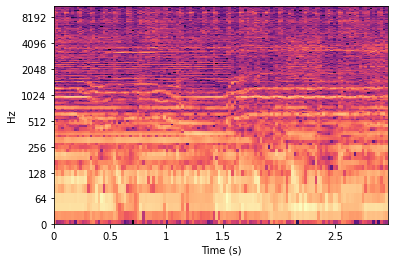

In [12]:
librosa.display.specshow(librosa.amplitude_to_db(training_slices_X[0][:, :, 0], ref=np.max), y_axis='log', x_axis='s')

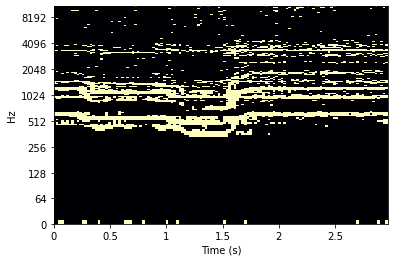

In [13]:
librosa.display.specshow(librosa.amplitude_to_db(training_slices_Y[0][:, :, 0], ref=np.max), y_axis='log', x_axis='s')

<h2 style="text-decoration:underline">U-net Model:</h2>

In [14]:
# STFT Model
model = u_net(img_width=128, img_height=512, img_channels=1, metrics=['accuracy'], batch_norm=True, filters=16)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
# Log-Mel Model
#model = u_net(img_width=128, img_height=128, img_channels=1, metrics=['accuracy'], batch_norm=True, filters=4)

<h2 style="text-decoration:underline">Training:</h2>

In [ ]:
num_of_epochs = 2
batch_size = 32
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
             tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min'),
             tf.keras.callbacks.CSVLogger('model.log')]

result_training = model.fit(training_slices_X, training_slices_Y, batch_size=batch_size, epochs=num_of_epochs, 
                            callbacks=callbacks, validation_data=(validation_slices_X, validation_slices_Y), 
                            shuffle=True)


<h2 style="text-decoration:underline">Evaluation:</h2>

In [ ]:
predictions = model.predict(test_slices_X, verbose=1)

predictions = np.where(predictions > 0.5, 1, 0)

(sdr, sir, sar, perm) = mir_eval.separation.bss_eval_sources(test_slices_Y, predictions)

In [ ]:
print("SDR: " + sdr)
print("SIR: " + sir)
print("SAR: " + sar)

<h4 style="text-decoration:underline">Inverse STFT (test):</h4>

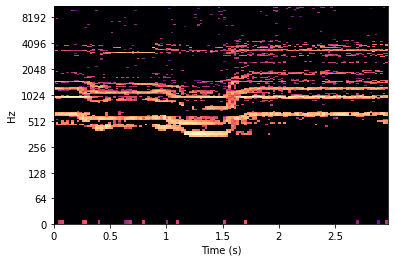

In [29]:
vocal_only = np.multiply(training_slices_X[0][:, :, 0], training_slices_Y[0][:, :, 0])
librosa.display.specshow(librosa.amplitude_to_db(vocal_only, ref=np.max), y_axis='log', x_axis='s')

In [30]:
vocal_only = librosa.istft(vocal_only, length=128*512, hop_length=512)
print(len(vocal_only))
Audio(vocal_only, rate=22050)